# Майнор по Анализу Данных, Группа ИАД-2
## 24/05/2017  Рекомендательные системы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Коллаборативная фильтрация

Метод коллаборативной фильтрации работает по принципу похожести пользователей (**User-based collaborative filtering**) или похожести товаров (**Item-based collaborative filtering**). 

Введем обозначения:
* $R_{ui}$ - оценка, которую дал пользователь $u$ товару $i$
* $\hat{R}_{ui}$ - прогноз оценки
* $s_{uv}$ - похожесть между пользователями $u$ и $v$
* $s_{ij}$ - похожесть между товарами $i$ и $j$
* $N(u)$ - Множество пользователей, наиболее похожих на $u$
* $N(i)$ - Множество товаров, наиболее похожих на $i$

Прогноз **user-based collaborative filtering** вычисляется по следующей формуле
$$ \hat{R}_{ui} = \frac{\sum_{v \in N(u)} s_{uv} R_{vi}}{\sum_{v \in N(u)} s_{uv}} $$

Походесть между пользователями можно вычислить разными способами, например с помощью корреляции или косинусной меры
$$ s_{uv} = \frac{R_u^T R_v}{\lVert R_u \rVert_2 \lVert R_v \rVert_2}$$
Стоит отметить, что при подсчете похожести должны учитываться только те товары, для которых и у $u$ и у $v$ есть какая-то оценка

<center><img src='http://comsysto.files.wordpress.com/2013/02/userbased.png' width=700></center>

Похожим образом делается оценка с помощью **item-based collaborative filtering**:

$$\hat{R}_{u i} = \frac{\sum_{j \in N(i)} s_{ij} R_{u j}}{\sum_{j \in N(i)} s_{ij}}$$

<center><img src='http://dataconomy.com/wp-content/uploads/2015/03/Beginners-Guide-Recommender-Systems-Content-Based-Filtering.png' width=350></center>

# Рейтинги фильмов

* Загрузите данные о рейтингах и фильмах
* Разбейте данные на обучение и контроль в пропорции 80/20
* Реализуйте функцию расчета попарных схожестей между пользователями
* Реализуйте метод расчета рекомендаций на основе $K$ наиболее похожих пользователей. Постройте график зафисимости ошибки MAE от $K$ (1-10)
* Выполните нормализацию рейтингов с помощью вычитания средней оценки $\bar{R}_u$ каждого из пользователей и повторите предыдущий 2 шага. В этом случае предсказание выполняется следующим образом
$$ \hat{R}_{ui} = \bar{R}_u + \frac{\sum_{v \in N(u)} s_{uv} (R_{vi} - \bar{R}_v)}{\sum_{v \in N(u)} s_{uv}} $$
* Перейдите к Item-Based подходу и повторите предыдущие шаги

In [111]:
filepath = './data/user_ratedmovies.dat'
df_rates = pd.read_csv(filepath, sep='\t')

In [112]:
filepath = './data/movies.dat'
df_movies = pd.read_csv(filepath, sep='\t', encoding='iso-8859-1')

In [113]:
movie_counts = df_rates.movieID.value_counts()

In [114]:
movies_one_watch = movie_counts[movie_counts == 1]

In [115]:
idx = df_rates.movieID.isin(movies_one_watch.index)
df_rates = df_rates.loc[~idx, :]

In [116]:
df_rates.head()

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
0,75,3,1.0,29,10,2006,23,17,16
1,75,32,4.5,29,10,2006,23,23,44
2,75,110,4.0,29,10,2006,23,30,8
3,75,160,2.0,29,10,2006,23,16,52
4,75,163,4.0,29,10,2006,23,29,30


## Перекодируем ID фильмов

In [117]:
from sklearn.preprocessing import LabelEncoder

In [118]:
mov_enc = LabelEncoder()
mov_enc.fit(df_rates.movieID.values)
n_movies = df_rates.movieID.nunique()

In [119]:
user_enc = LabelEncoder()
user_enc.fit(df_rates.userID.values)
n_users = df_rates.userID.nunique()

In [120]:
df_rates.loc[:, 'movieID'] = mov_enc.transform(df_rates.movieID.values)
df_rates.loc[:, 'userID'] = user_enc.transform(df_rates.userID.values)

In [121]:
df_rates.head()

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
0,0,2,1.0,29,10,2006,23,17,16
1,0,31,4.5,29,10,2006,23,23,44
2,0,104,4.0,29,10,2006,23,30,8
3,0,147,2.0,29,10,2006,23,16,52
4,0,150,4.0,29,10,2006,23,29,30


## Разбиваем на обучение и контроль

In [122]:
from sklearn.model_selection import train_test_split

In [123]:
df_rates_train, df_rates_test = train_test_split(df_rates, 
                                                 test_size=0.2, 
                                                 random_state=123)

In [124]:
df_rates_test.shape

(171000, 9)

In [125]:
df_rates_test.head()

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
431521,1019,1000,3.0,27,10,2003,19,43,35
769718,1891,3540,4.5,24,7,2007,3,25,35
10766,42,357,2.0,2,9,2007,13,0,20
572429,1362,1346,2.0,17,9,2000,5,47,44
520032,1238,2239,3.0,4,10,1999,15,20,22


## Делаем матрицу с рейтингами

In [109]:
df_rates_test.userID.isin(df_rates_train.userID).all()

True

In [110]:
df_rates_train.movieID.value_counts()

2242    1333
336     1291
4481    1258
278     1242
5338    1202
299     1170
2507    1170
451     1162
6423    1158
2600    1152
556     1142
3832    1127
1093    1098
695     1097
2414    1094
1348    1091
244     1069
3757    1062
1024    1062
3152    1052
1022    1036
5854    1036
6162    1021
1470    1020
49      1011
553     1009
0       1006
1035     997
4896     997
104      995
        ... 
5781       1
7715       1
7836       1
5510       1
7017       1
7231       1
721        1
5480       1
3828       1
7253       1
7360       1
9239       1
1781       1
2556       1
6585       1
8698       1
3144       1
6901       1
7117       1
3899       1
3971       1
8390       1
8407       1
4992       1
5230       1
6131       1
7674       1
9424       1
8471       1
9326       1
Name: movieID, dtype: int64

In [126]:
from scipy.sparse import coo_matrix

In [127]:
n_users_train = df_rates.userID.nunique()
R_train = coo_matrix((df_rates_train.rating, 
                     (df_rates_train.userID.values, df_rates_train.movieID.values)),
                     shape=(n_users, n_movies))

In [128]:
R_train.shape

(2113, 9507)

In [129]:
R_train

<2113x9507 sparse matrix of type '<type 'numpy.float64'>'
	with 683996 stored elements in COOrdinate format>

In [130]:
R_train = R_train.toarray()

In [131]:
R_train

array([[ 0. ,  0. ,  1. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ..., 
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 4.5,  0. ,  2. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

## Считаем попарные рейтинги

In [132]:
from scipy.spatial.distance import cosine
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.spatial.distance import correlation
from sklearn.metrics import pairwise_distances

In [70]:
R_train

array([[ 0. ,  0. ,  1. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ..., 
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 4.5,  0. ,  2. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

In [133]:
def similarity(u, v):
    idx = (u != 0) & (v != 0)
    if any(idx):
        return -cosine(u[idx], v[idx])+2
    else:
        return 0

In [134]:
%%time
D = pdist(R_train, metric=similarity)

CPU times: user 4min 9s, sys: 2.75 s, total: 4min 12s
Wall time: 4min 20s


In [135]:
D = squareform(D)

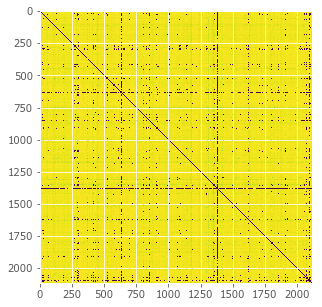

In [136]:
plt.imshow(D)

## Делаем рекомендации

In [137]:
df_rates_test.head()

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
431521,1019,1000,3.0,27,10,2003,19,43,35
769718,1891,3540,4.5,24,7,2007,3,25,35
10766,42,357,2.0,2,9,2007,13,0,20
572429,1362,1346,2.0,17,9,2000,5,47,44
520032,1238,2239,3.0,4,10,1999,15,20,22


In [138]:
from tqdm import tqdm_notebook

In [191]:
watched_users = R_train[:, int(r['movieID'])]

In [196]:
predicted_ratings = []

for i, r in tqdm_notebook(df_rates_test.iterrows()):
    watched_users = np.where(R_train[:, int(r['movieID'])])[0]
    sim = D[int(r['userID']), watched_users]
    sorted_idx = np.argsort(sim)
    for k in range(1, 11):
        
        ratings = R_train[watched_users[sorted_idx[-k:]], int(r['movieID'])]
        
        sim_k = sim[sorted_idx[-k:]]
        
        prediction = ratings.dot(sim_k)/(sim_k.sum()) 

        predicted_ratings.append({'userID': r['userID'],
                                  'movieID': r['movieID'],
                                  'prediction': prediction,
                                  'k': k})

/Users/andrey.shestakov/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars


In [197]:
df_pred = pd.DataFrame.from_dict(predicted_ratings)

In [200]:
df_pred = df_pred.set_index(['movieID', 'userID', 'k'])

In [201]:
df_pred.head()

prediction
movieID userID k            
1000.0  1019.0 1    2.500000
               2    3.499850
               3    3.833018
               4    4.124560
               5    4.099670

In [205]:
df_rates_test = df_rates_test.set_index(['movieID', 'userID'])

In [207]:
df_rates_test.head()

,,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
movieID,userID,,,,,,,
1000,1019,3.0,27,10,2003,19,43,35
3540,1891,4.5,24,7,2007,3,25,35
357,42,2.0,2,9,2007,13,0,20
1346,1362,2.0,17,9,2000,5,47,44
2239,1238,3.0,4,10,1999,15,20,22


In [225]:
df_pred_unstack = df_pred.unstack()

In [228]:
df_rates_test.loc[(357, 42)]

rating            2.0
date_day          2.0
date_month        9.0
date_year      2007.0
date_hour        13.0
date_minute       0.0
date_second      20.0
Name: (357, 42), dtype: float64

In [229]:
df_pred_unstack.loc[(357, 42), :]

            k 
prediction  1     4.500000
            2     4.500000
            3     4.333383
            4     3.875386
            5     3.700542
            6     3.584049
            7     3.429518
            8     3.500681
            9     3.500606
            10    3.550435
Name: (357.0, 42.0), dtype: float64